## Occupancy Prediction Using BNN With Physics Based Regularizer for CASE1

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler as Scaler
from termcolor import colored
from simple_colors import *
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline 
plt.style.use('ggplot') #Styling configuration for matplotlib
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 14

'''import warnings
# Ignore future warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)'''
import warnings
warnings.filterwarnings('ignore')


c:\Users\scis\.conda\envs\allmen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Synthetic Data Function for Date


In [2]:
def read_data(file_path):
    data = pd.read_csv(file_path, header=0)
    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data["day"] = data["date"].dt.day
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    data["weekday"] = data[["date"]].apply(
        lambda x: dt.datetime.strftime(x["date"], "%A"), axis=1
    )
    return data


def plot_dist(ax, x, y, title):
    ax.plot(x, y, color="green")
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%A, %b %d"))
    ax.set_xlim([min(x), max(x)])
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

### Load All Dataset Cases


In [3]:
training_data = read_data("../Dataset/datatraining.txt")
door_open_test_data = read_data("../Dataset/datatest.txt")
door_close_test_data = read_data("../Dataset/datatest2.txt")
combined_data = read_data("../Dataset/occupant_combined.csv")
original_data = read_data('../Dataset/original_data.csv')

In [4]:
case1 = original_data
case2 = combined_data
case3 = training_data

In [5]:
case2

,date,Temp,Humidity,Light,CO2,HumidityRatio,syn_temp,Wind_speed,HDD,occupancy,year,month,day,hour,minute,second,weekday
0,2015-02-02 14:19:00,23.7000,26.2720,585.20000,749.20000,0.00476,1.73,6.42,0.67792,1,2015,2,2,14,19,0,Monday
1,2015-02-02 14:19:00,23.7180,26.2900,578.40000,760.40000,0.00477,1.73,6.42,0.67792,1,2015,2,2,14,19,0,Monday
2,2015-02-02 14:21:00,23.7300,26.2300,572.66667,769.66667,0.00477,1.73,6.42,0.67792,1,2015,2,2,14,21,0,Monday
3,2015-02-02 14:22:00,23.7225,26.1250,493.75000,774.75000,0.00474,1.73,6.42,0.67792,1,2015,2,2,14,22,0,Monday
4,2015-02-02 14:23:00,23.7540,26.2000,488.60000,779.00000,0.00477,1.73,6.42,0.67792,1,2015,2,2,14,23,0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,2015-02-18 09:15:00,20.8150,27.7175,429.75000,1505.25000,0.00421,13.95,10.49,0.16875,1,2015,2,18,9,15,0,Wednesday
20556,2015-02-18 09:16:00,20.8650,27.7450,423.50000,1514.50000,0.00423,13.95,10.49,0.16875,1,2015,2,18,9,16,0,Wednesday
20557,2015-02-18 09:16:00,20.8900,27.7450,423.50000,1521.50000,0.00424,13.95,10.49,0.16875,1,2015,2,18,9,16,0,Wednesday
20558,2015-02-18 09:17:00,20.8900,28.0225,418.75000,1632.00000,0.00428,13.95,10.49,0.16875,1,2015,2,18,9,17,0,Wednesday


## Data Virtualization


### Show distribution average occupant status over time from combined dataset


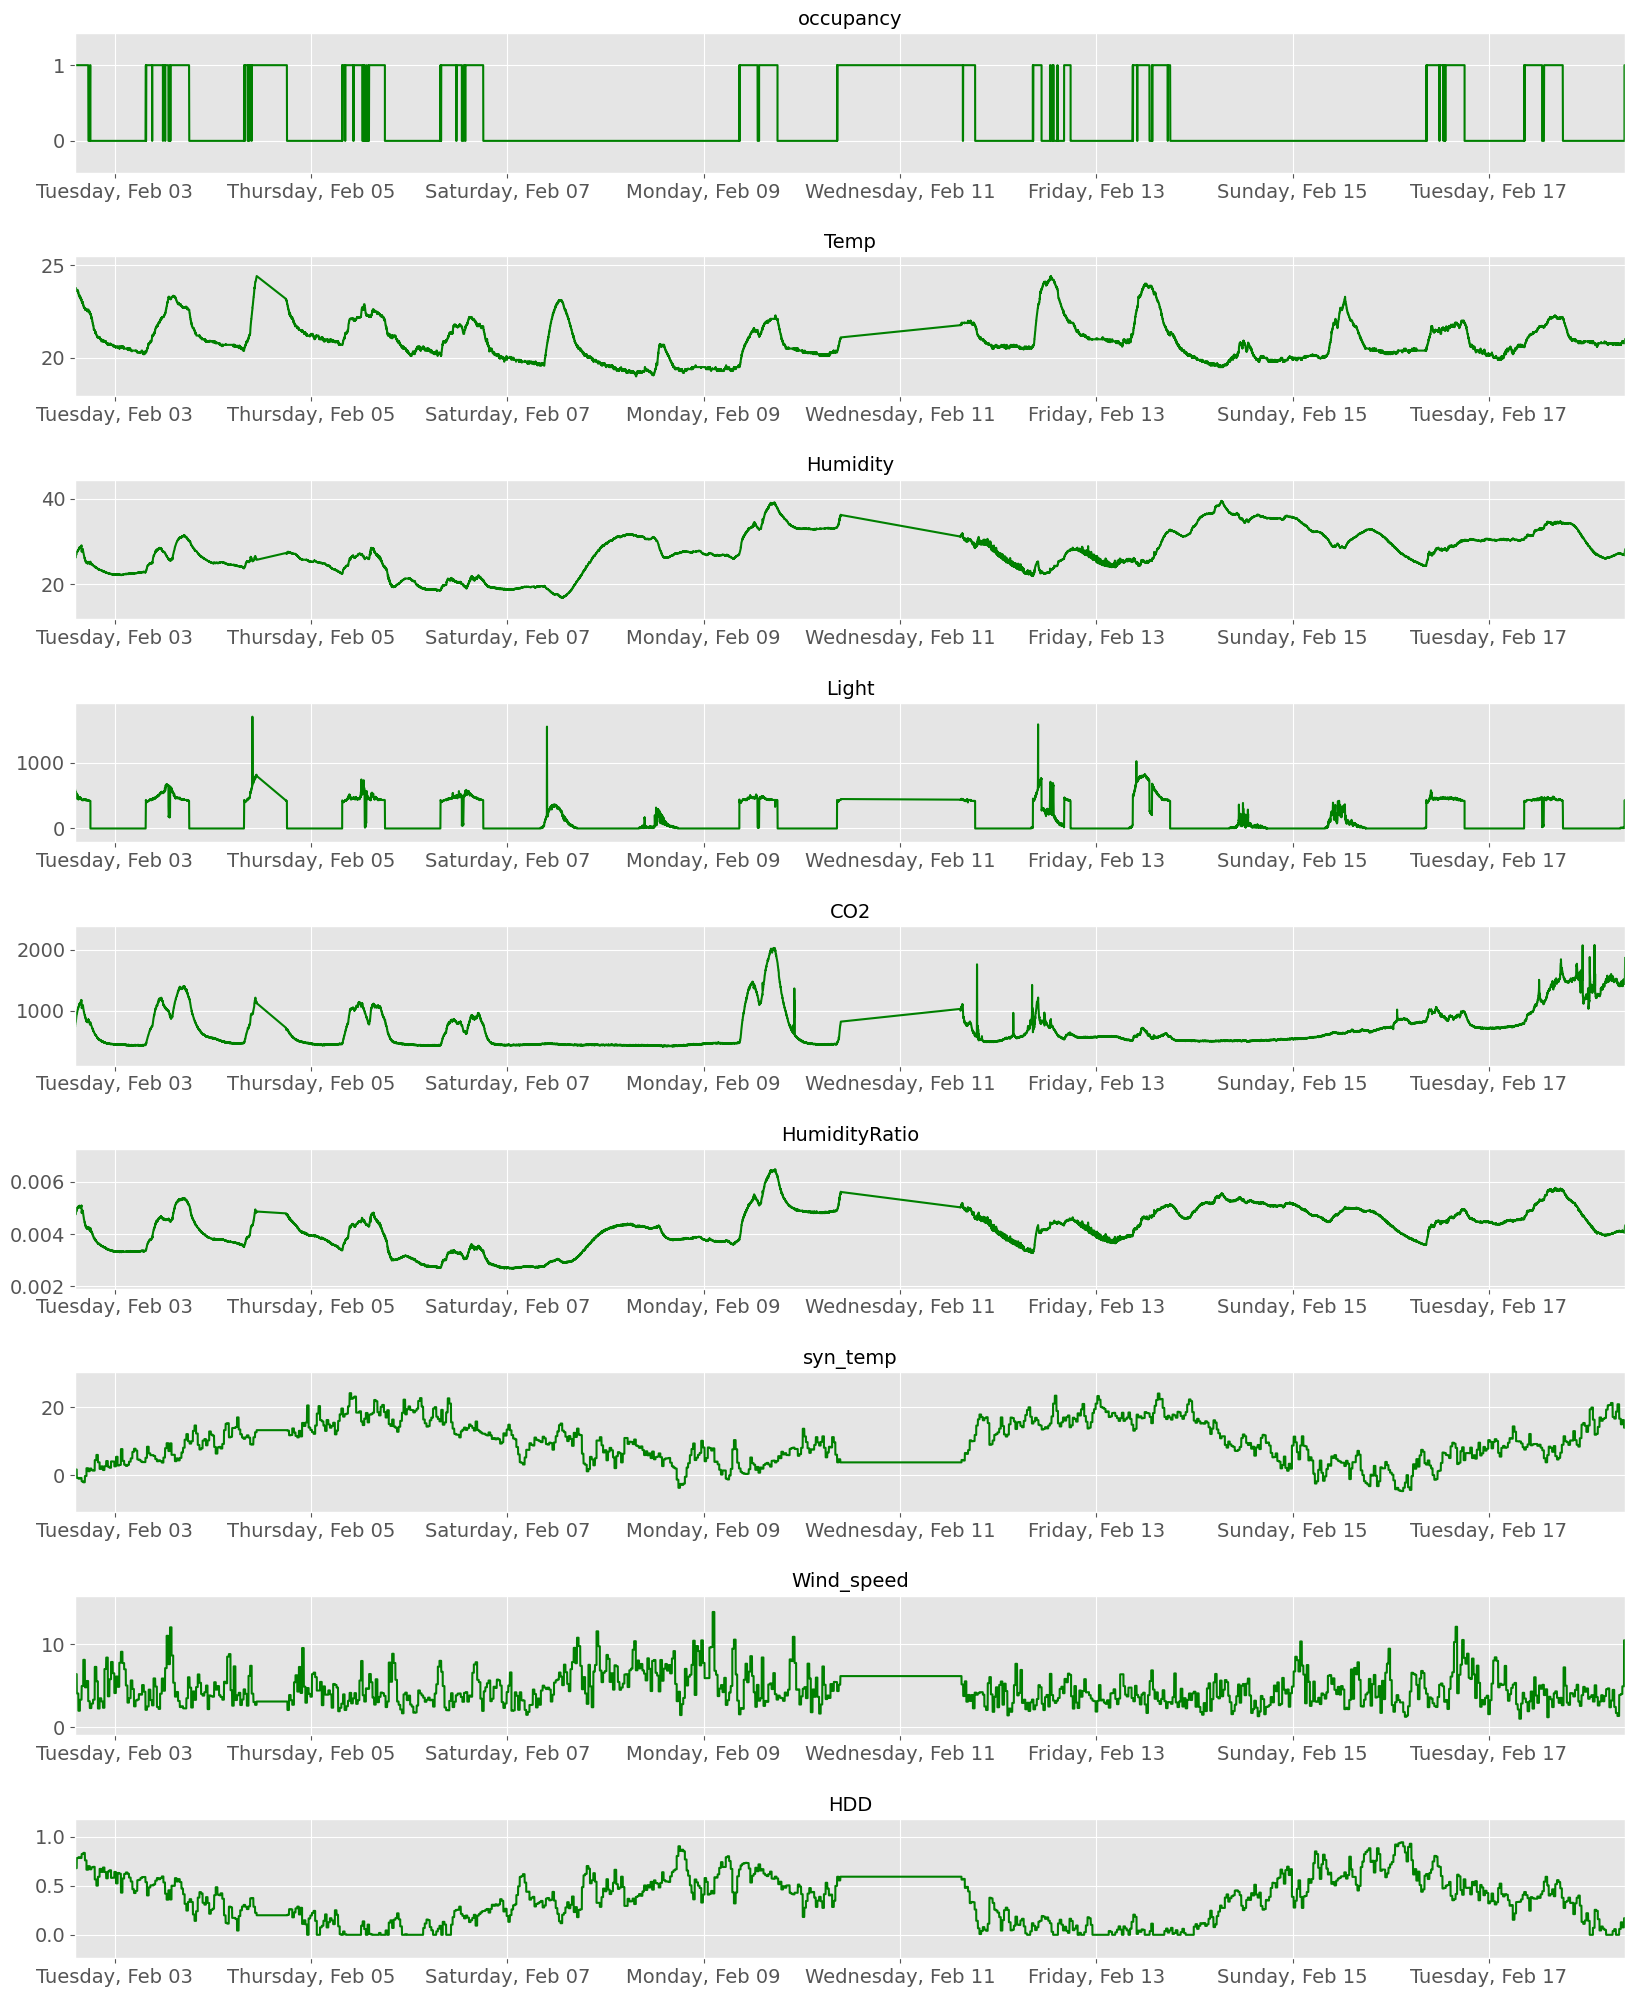

In [6]:
subset_features = case2[
    [
        "occupancy",
        "Temp",
        "Humidity",
        "Light",
        "CO2",
        "HumidityRatio",
        "syn_temp",
        "Wind_speed",
        "HDD",
    ]
]

fig, axs = plt.subplots(nrows=len(subset_features.columns.values), figsize=(20, 25))
for i in range(0, len(subset_features.columns.values)):
    plot_dist(
        axs[i],
        case2["date"],
        subset_features[subset_features.columns.values[i]],
        subset_features.columns.values[i],
    )
plt.subplots_adjust(hspace=0.6)
plt.show()

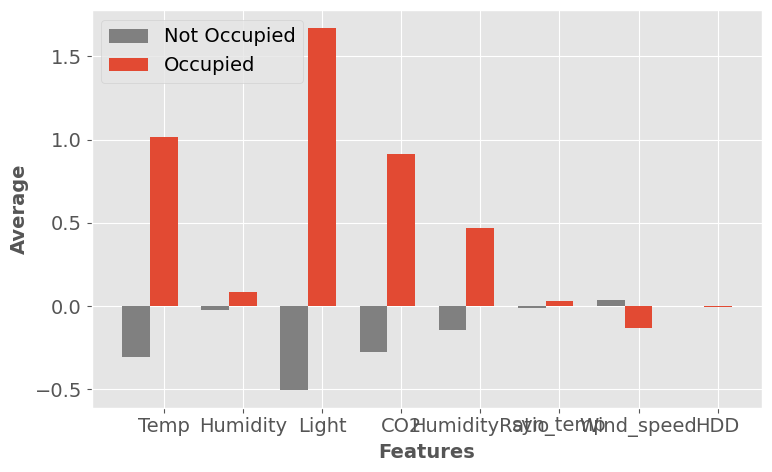

In [7]:
data_scaled = combined_data[
    [
        "Temp",
        "Humidity",
        "Light",
        "CO2",
        "HumidityRatio",
        "syn_temp",
        "Wind_speed",
        "HDD",
        "occupancy",
    ]
]

data_scaled.loc[:, "Temp"] = scale(data_scaled["Temp"])
data_scaled.loc[:, "Humidity"] = scale(data_scaled["Humidity"])
data_scaled.loc[:, "Light"] = scale(data_scaled["Light"])
data_scaled.loc[:, "CO2"] = scale(data_scaled["CO2"])
data_scaled.loc[:, "HumidityRatio"] = scale(data_scaled["HumidityRatio"])
data_scaled.loc[:, "syn_temp"] = scale(data_scaled["syn_temp"])
data_scaled.loc[:, "Wind_speed"] = scale(data_scaled["Wind_speed"])
data_scaled.loc[:, "HDD"] = scale(data_scaled["HDD"])

summary_occupancy = (
    data_scaled[
        [
            "Temp",
            "Humidity",
            "Light",
            "CO2",
            "HumidityRatio",
            "syn_temp",
            "Wind_speed",
            "HDD",
            "occupancy",
        ]
    ]
    .groupby(["occupancy"], as_index=False)
    .mean()
)

n_groups = 8
fig, ax = plt.subplots(figsize=(8, 5))
index = np.arange(n_groups)
bar_width = 0.35

rects_no = plt.bar(
    index,
    np.asarray(
        summary_occupancy[
            [
                "Temp",
                "Humidity",
                "Light",
                "CO2",
                "HumidityRatio",
                "syn_temp",
                "Wind_speed",
                "HDD",
            ]
        ]
    )[0],
    bar_width,
    color="grey",
    label="Not Occupied",
)


rects_o = plt.bar(
    index + bar_width,
    np.asarray(
        summary_occupancy[
            [
                "Temp",
                "Humidity",
                "Light",
                "CO2",
                "HumidityRatio",
                "syn_temp",
                "Wind_speed",
                "HDD",
            ]
        ]
    )[1],
    bar_width,
    label="Occupied",
)

plt.xlabel("Features")
plt.ylabel("Average")
plt.xticks(
    index + bar_width,
    (
        "Temp",
        "Humidity",
        "Light",
        "CO2",
        "HumidityRatio",
        "syn_temp",
        "Wind_speed",
        "HDD",
    ),
)
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Check for Data Correlation


                   Temp  Humidity     Light       CO2  HumidityRatio   
Temp           1.000000 -0.173272  0.630650  0.609697       0.175755  \
Humidity      -0.173272  1.000000  0.012738  0.283459       0.921968   
Light          0.630650  0.012738  1.000000  0.454396       0.246174   
CO2            0.609697  0.283459  0.454396  1.000000       0.478608   
HumidityRatio  0.175755  0.921968  0.246174  0.478608       1.000000   

               syn_temp  Wind_speed       HDD  occupancy  
Temp           0.258983   -0.109056 -0.258751   0.568565  
Humidity      -0.313120    0.014473  0.313703   0.044859  
Light         -0.023845   -0.027170  0.024902   0.826291  
CO2           -0.022740   -0.175688  0.023436   0.543502  
HumidityRatio -0.204224   -0.051611  0.204814   0.243312  


<Axes: >

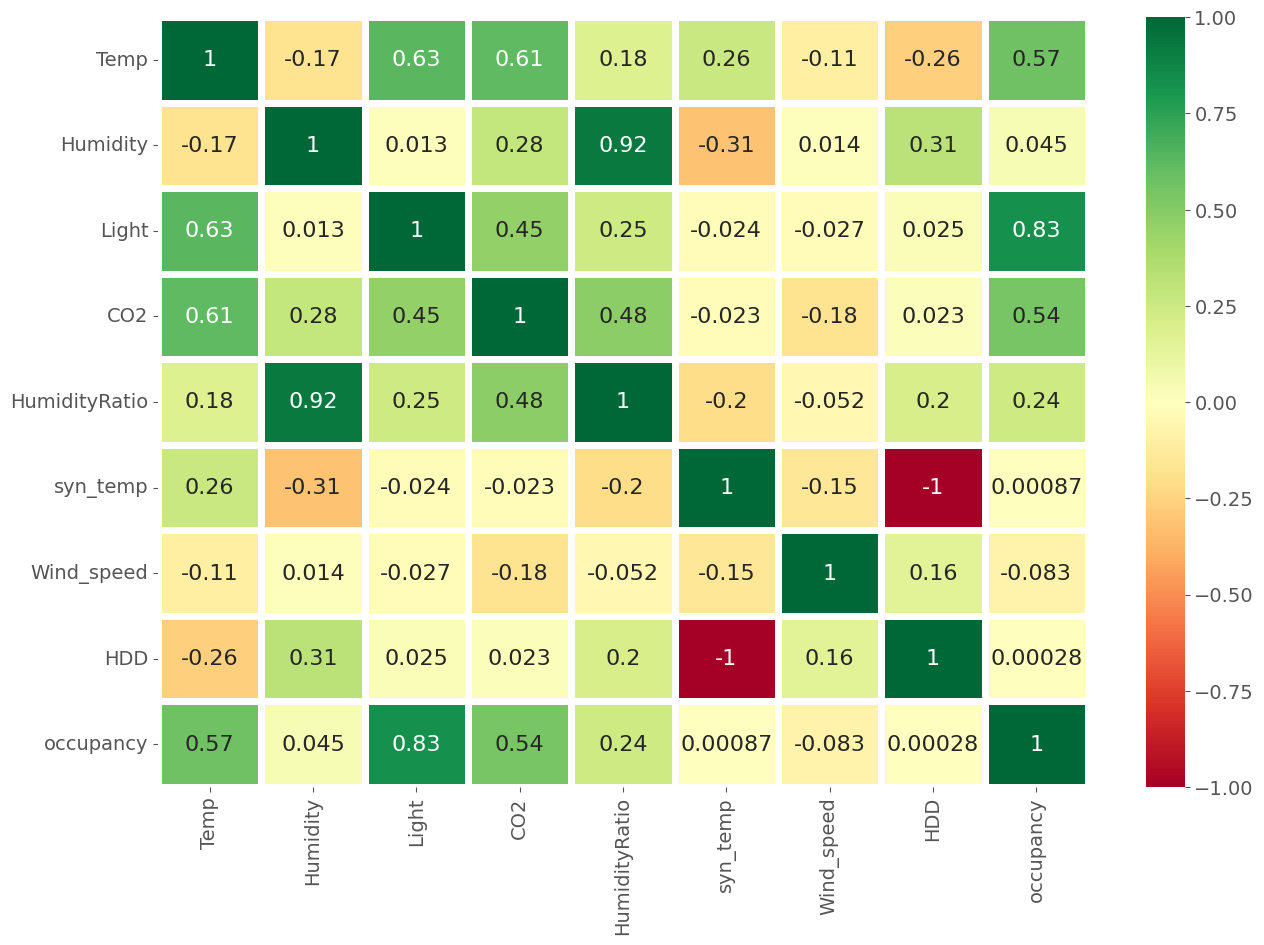

In [8]:
corr = combined_data.iloc[:, 1:10].corr(method="spearman", min_periods=1)
print(corr.head())

plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap="RdYlGn", annot=True, linewidth=5, vmax=1, vmin=-1, center=0)

### Check for outliers in dataset


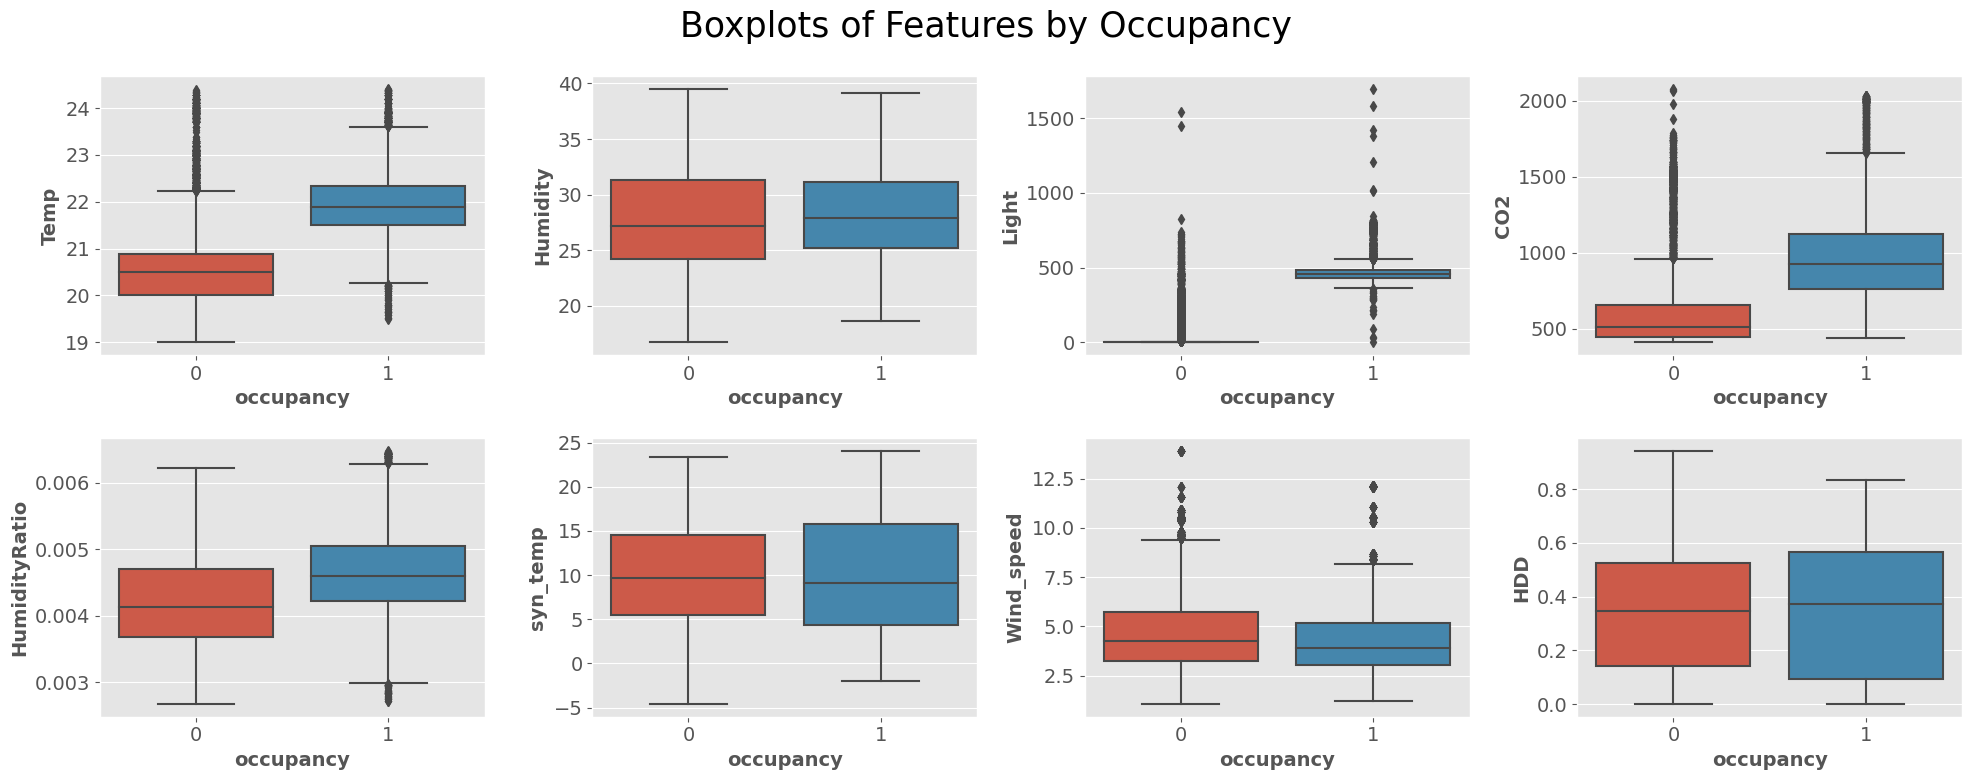

In [9]:
X = case2.iloc[:, 1:10]
y = case2["occupancy"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i in range(8):
    sns.boxplot(x=y, y=X.iloc[:, i], ax=axs[i])
    axs[i].set_ylabel(X.columns[i])


fig.suptitle("Boxplots of Features by Occupancy", fontsize=25)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

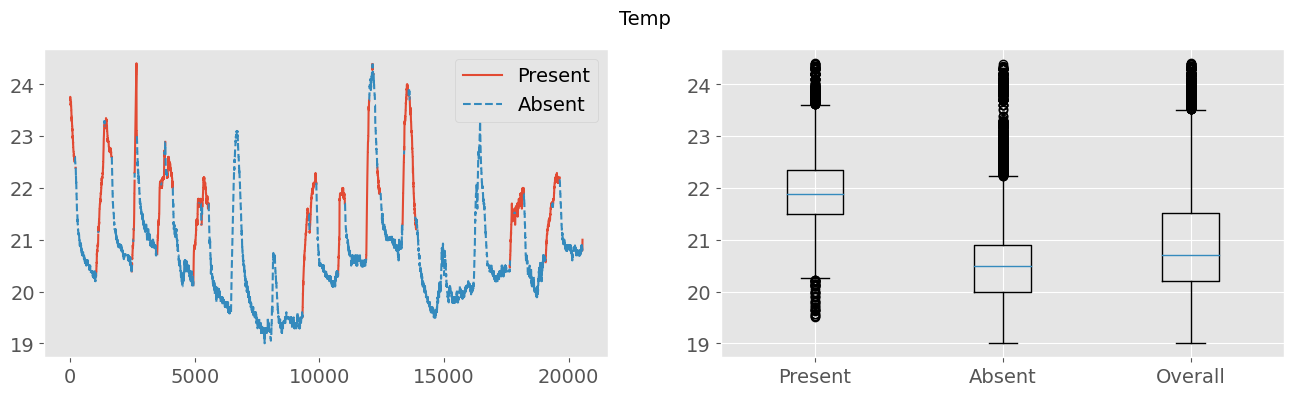

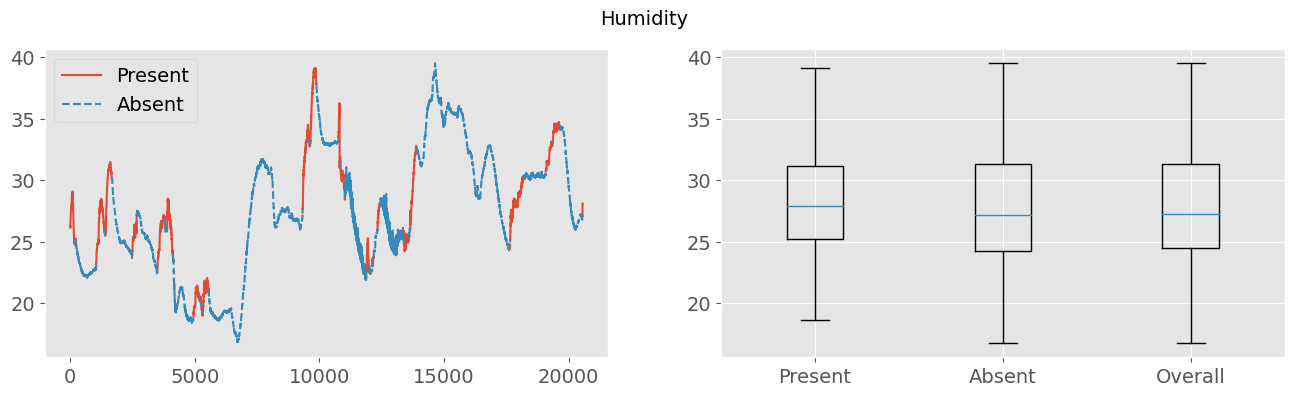

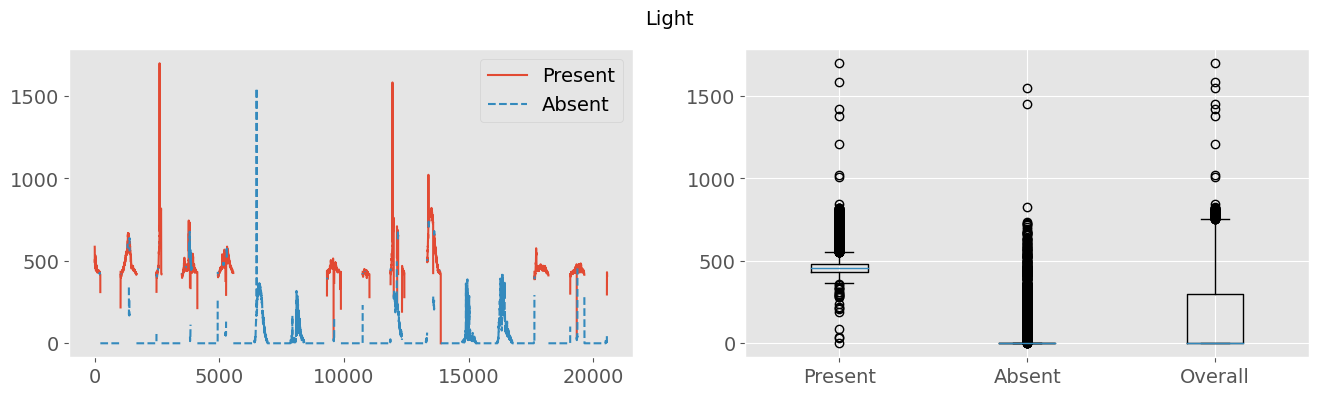

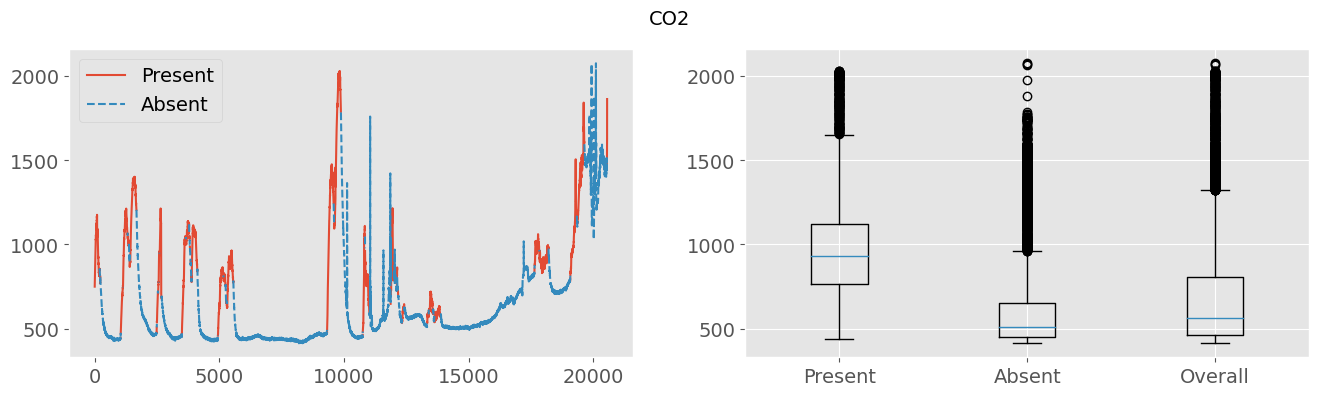

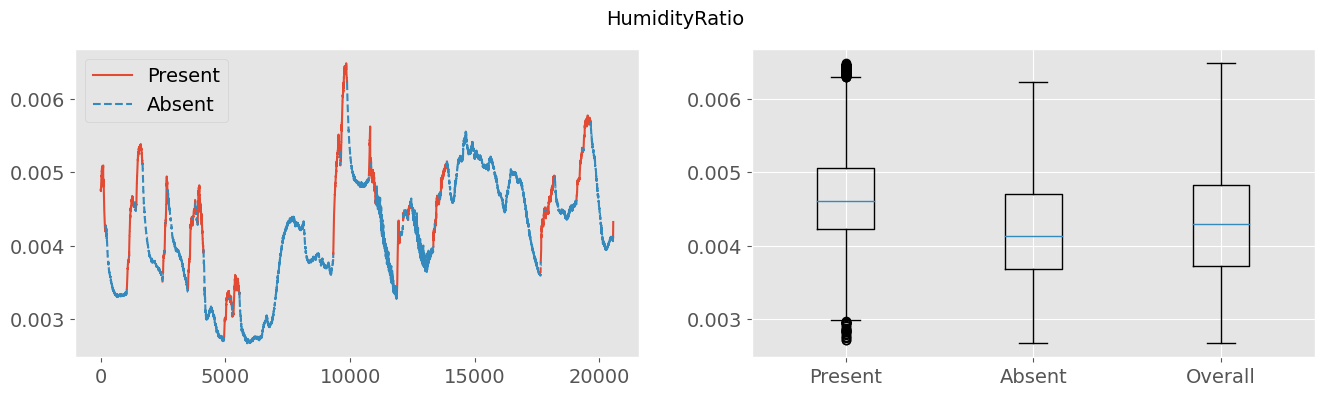

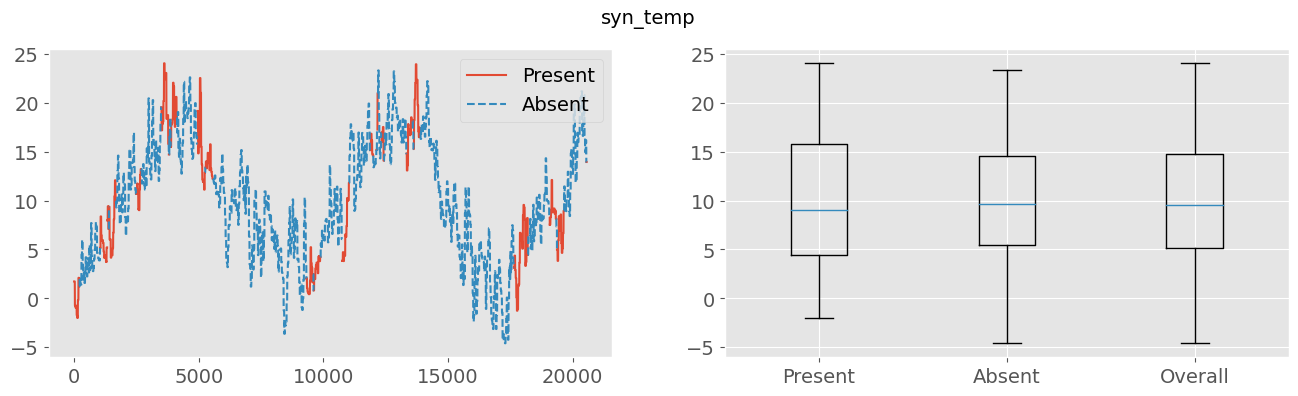

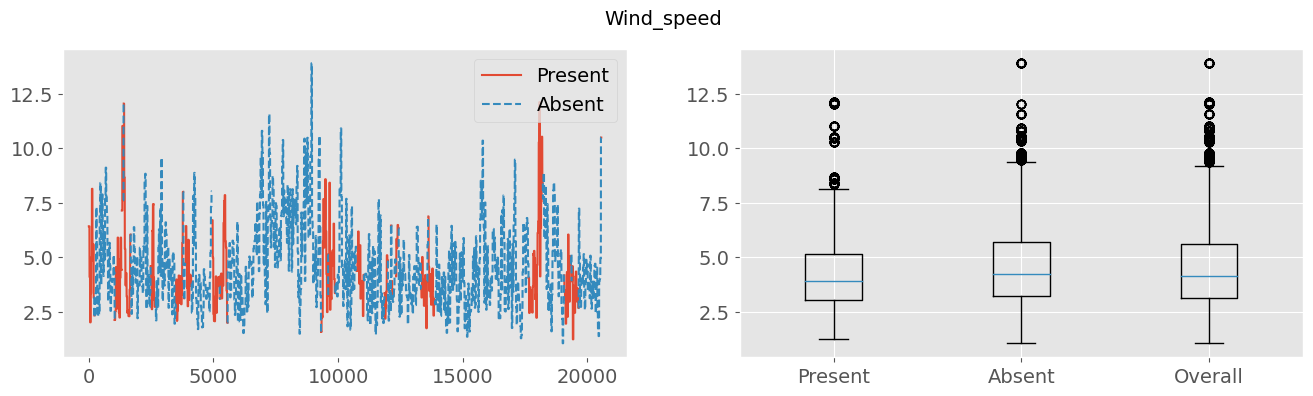

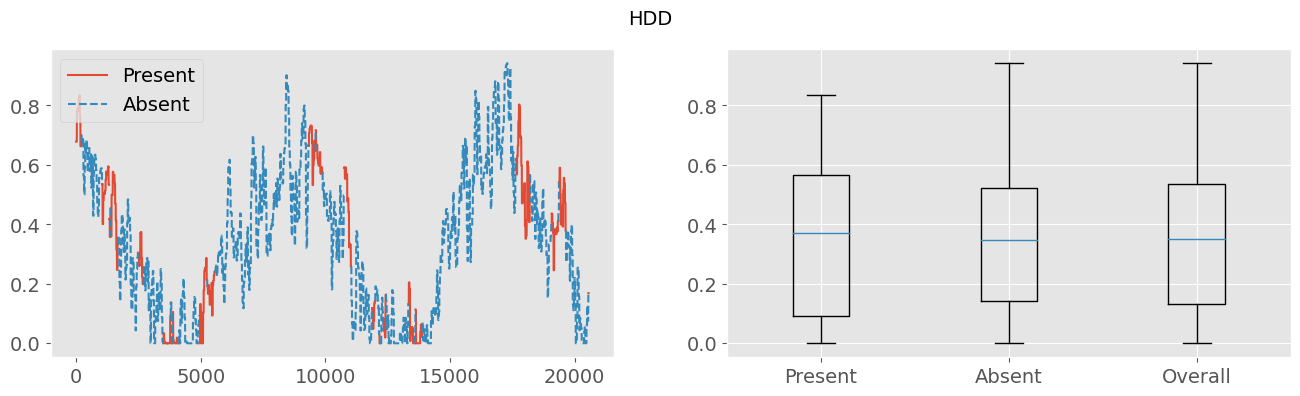

In [10]:
def occupancy_plot(df, all):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    fig.suptitle(all)
    ax1.plot(np.where(df.occupancy == 1, df[all], None), label="Present")
    ax1.plot(np.where(df.occupancy == 0, df[all], None), label="Absent", ls="--")
    ax1.grid()
    ax1.legend()

    ax2.boxplot([df[all][df.occupancy == 1], df[all][df.occupancy == 0], df[all]])
    ax2.set_xticklabels(["Present", "Absent", "Overall"])


for i in range(0, 8):
    occupancy_plot(X, X.columns[i])

### Removing Outliers present in the features


In [11]:
outliers = X
outliers = outliers[
    np.abs(outliers.Temp - outliers.Temp.mean()) <= 3 * outliers.Temp.std()
]
print(
    "1. Removing the Outliers on 'Temperature' has reduced the data size from {} to {}.".format(
        len(X), len(outliers)
    )
)
print("\n")
df = outliers[
    np.abs(outliers.Light - outliers.Light.mean()) <= 3 * outliers.Light.std()
]
print(
    "2. Removing the Outliers on 'Light' has reduced the data size from {} to {}.".format(
        len(outliers), len(df)
    )
)
print("\n")
outliers = df[np.abs(df.CO2 - df.CO2.mean()) <= 3 * outliers.CO2.std()]
print(
    "3. Removing the Outliers on 'CO2' has reduced the data size from {} to {}.".format(
        len(df), len(outliers)
    )
)
print("\n")

1. Removing the Outliers on 'Temperature' has reduced the data size from 20560 to 20417.


2. Removing the Outliers on 'Light' has reduced the data size from 20417 to 20261.


3. Removing the Outliers on 'CO2' has reduced the data size from 20261 to 19991.




In [12]:
outliers.describe()

,Temp,Humidity,Light,CO2,HumidityRatio,syn_temp,Wind_speed,HDD,occupancy
count,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000,19991.000000
mean,20.848690,27.584285,120.591132,673.960672,0.004201,9.835088,4.593920,0.348683,0.216948
std,0.995753,4.910707,199.095897,284.069642,0.000747,6.069613,1.984268,0.238636,0.412177
min,19.000000,16.745000,0.000000,412.750000,0.002670,-4.600000,1.050000,0.000000,0.000000
25%,20.166670,24.500000,0.000000,458.500000,0.003710,5.210000,3.160000,0.140830,0.000000
50%,20.700000,27.290000,0.000000,559.250000,0.004270,9.510000,4.160000,0.353750,0.000000
75%,21.463330,31.200000,225.250000,796.125000,0.004820,14.620000,5.650000,0.532920,0.000000
max,24.066670,39.500000,756.000000,1625.000000,0.005980,24.050000,13.900000,0.941670,1.000000


In [13]:
X.describe()

,Temp,Humidity,Light,CO2,HumidityRatio,syn_temp,Wind_speed,HDD,occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,9.870794,4.573160,0.347137,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,6.075036,1.971491,0.239046,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002670,-4.600000,1.050000,0.000000,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003720,5.150000,3.150000,0.133750,0.000000
50%,20.700000,27.290000,0.000000,565.416665,0.004290,9.560000,4.130000,0.351670,0.000000
75%,21.525000,31.290000,301.000000,804.666670,0.004830,14.790000,5.590000,0.535420,0.000000
max,24.408330,39.500000,1697.250000,2076.500000,0.006480,24.050000,13.900000,0.941670,1.000000


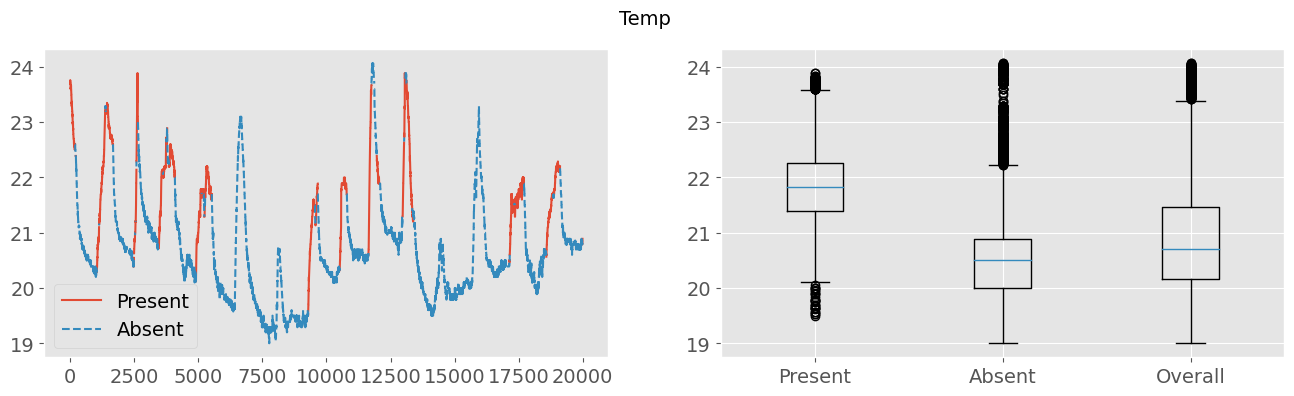

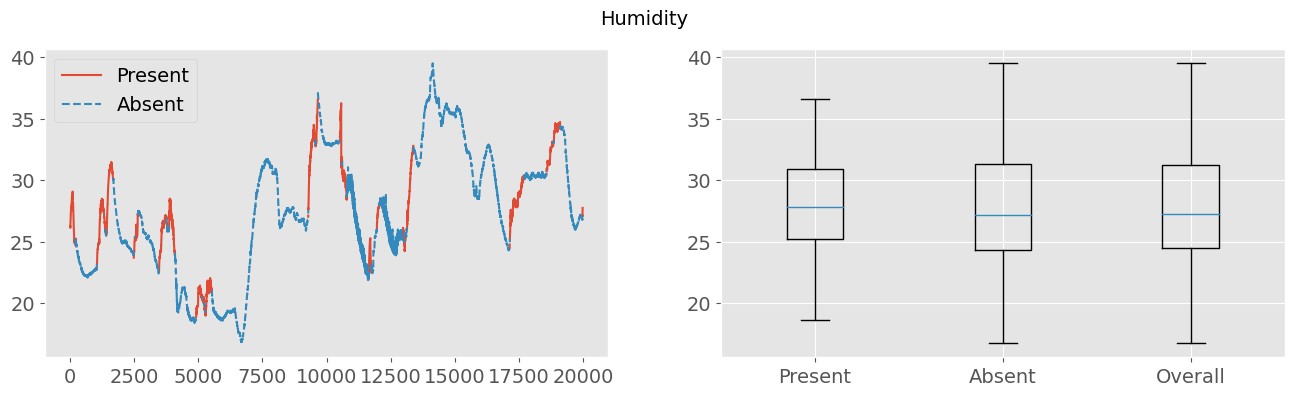

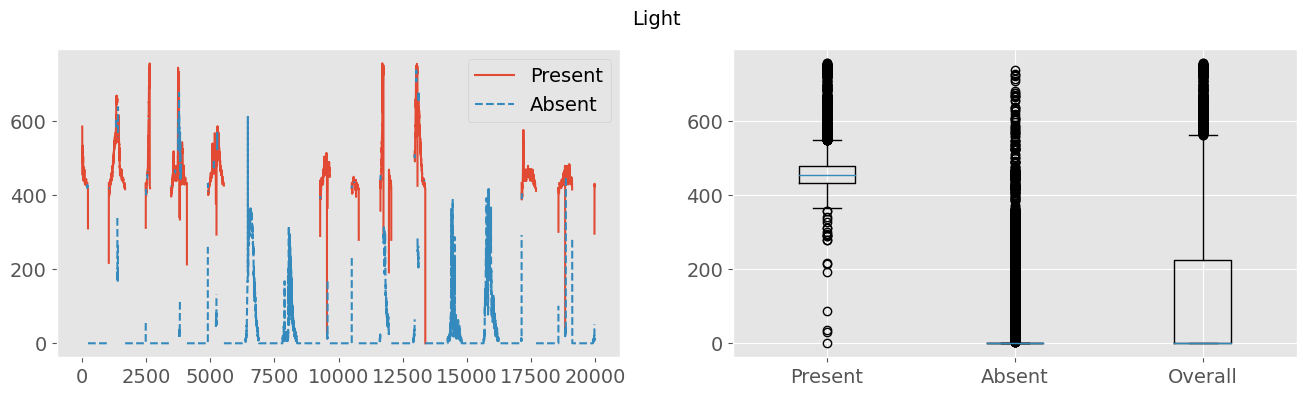

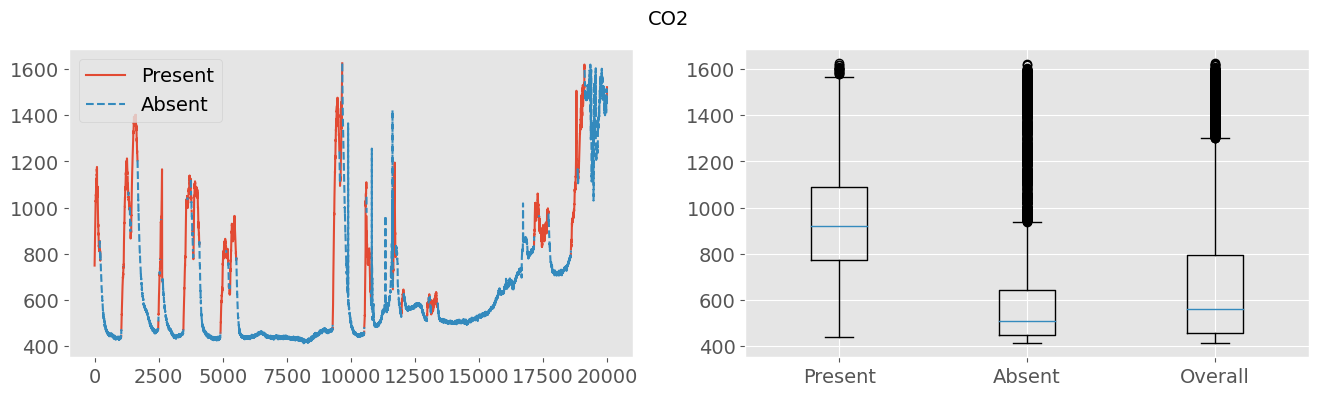

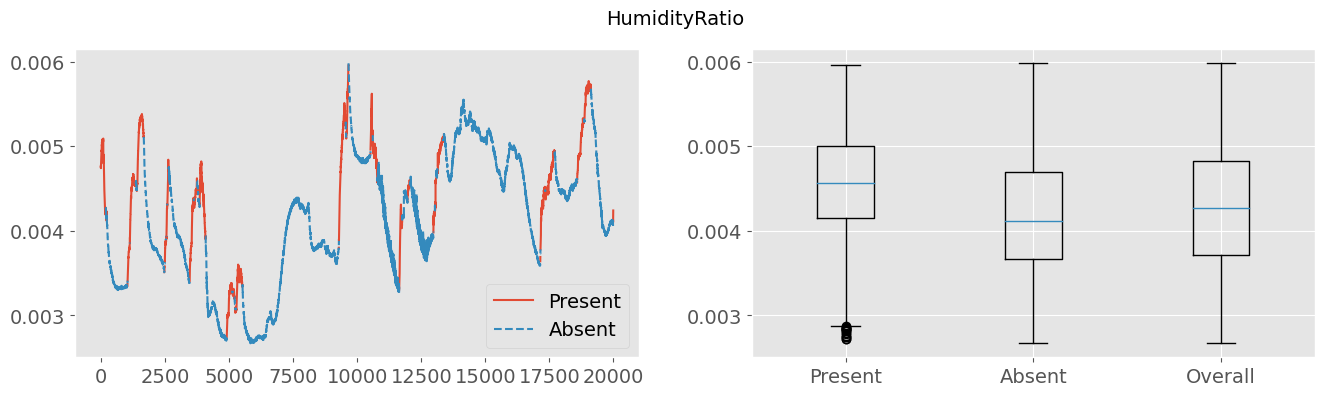

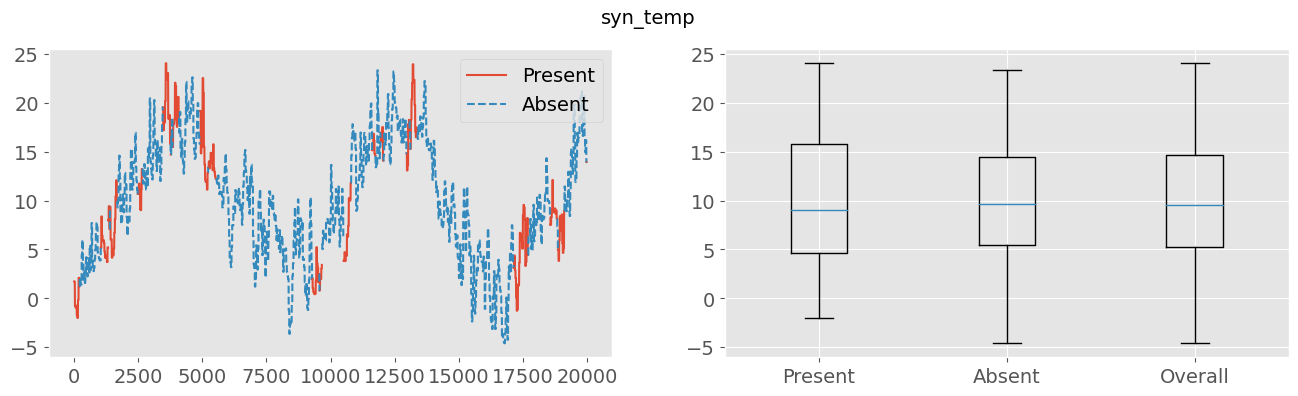

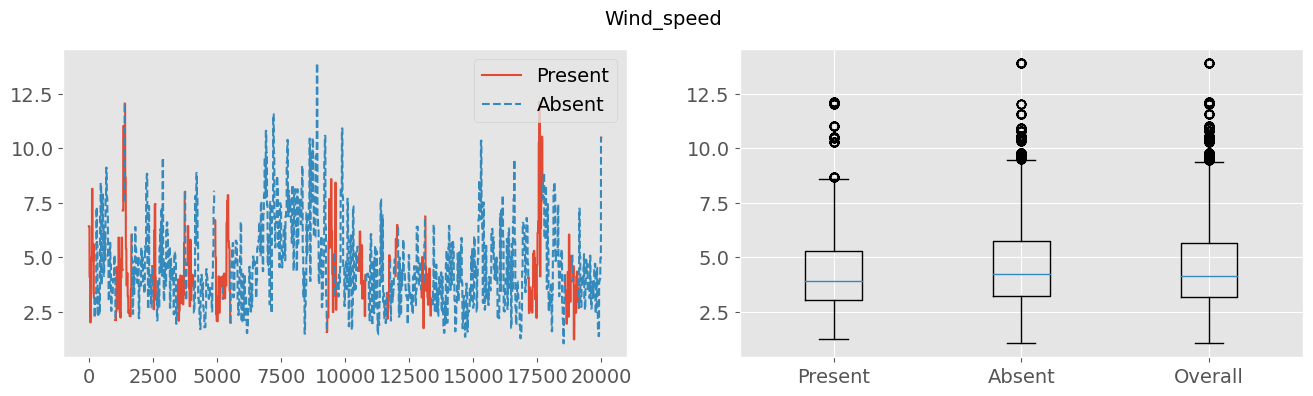

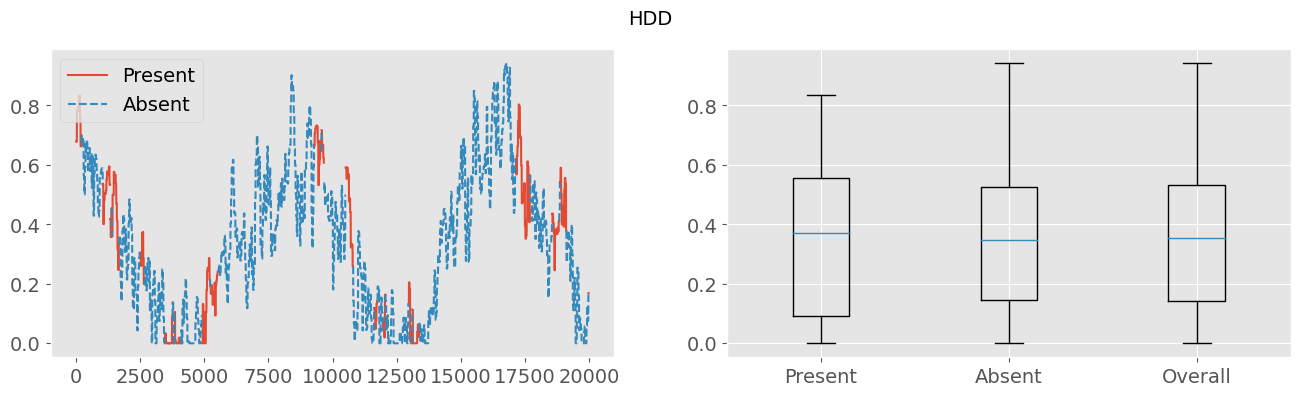

In [14]:
for i in range(0, 8):
    occupancy_plot(outliers, outliers.columns[i])

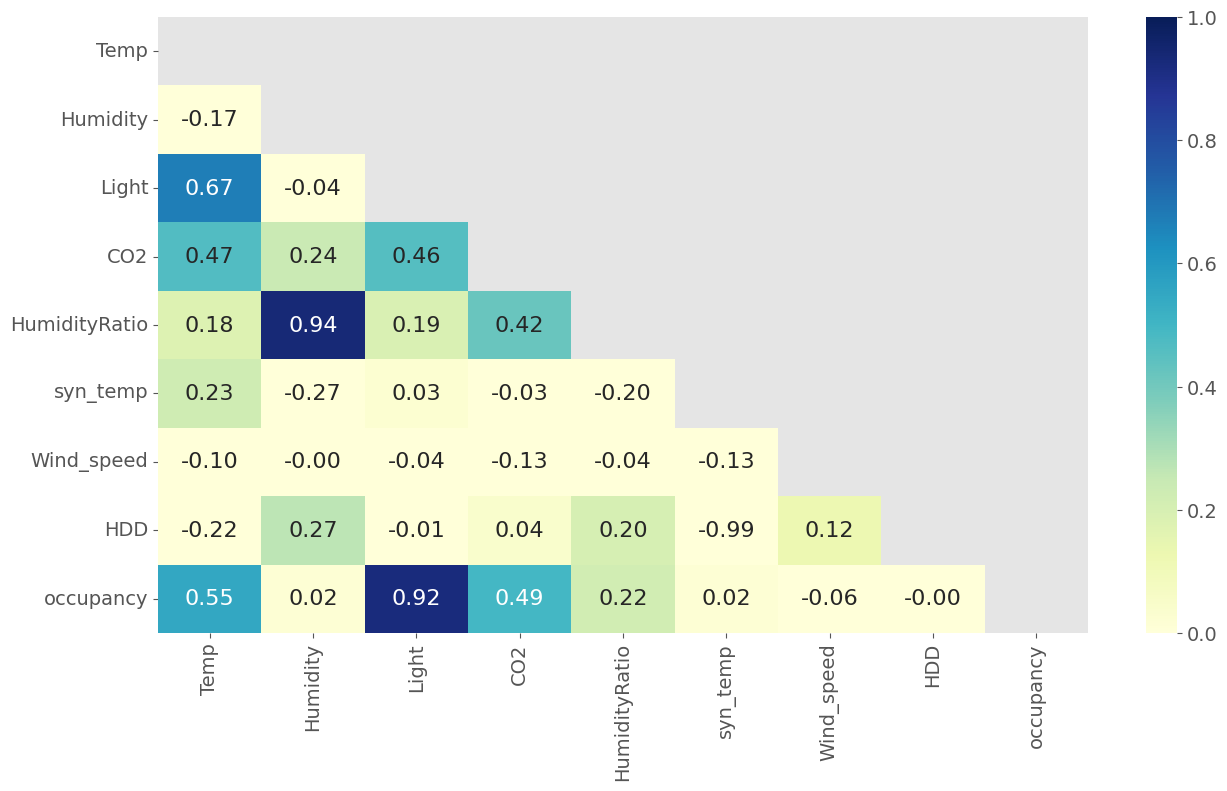

In [15]:
mask = np.triu(np.ones_like(outliers.corr(method="spearman")))
plt.figure(figsize=(15, 8))
sns.heatmap(
    outliers.corr(), annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu", vmin=0, vmax=1
)
plt.yticks(rotation=0)
plt.grid(False)
plt.show()

# 3. Selected Algorithms for Occupancy Prediction

- Bayesian Neural Network
- BNN + PBR
- Naive Bayes
- Support Vector Machine (SVM)
- Gradient Boosting


In [16]:
case2 = outliers
case2.columns

Index(['Temp', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'syn_temp',
       'Wind_speed', 'HDD', 'occupancy'],
      dtype='object')

## Data Splitting and shapping for training


In [17]:
from sklearn.preprocessing import MinMaxScaler


def prepare_dataset(data, size):
    x_data = []
    y_data = []

    l = len(data) - size

    for i in range(l):
        x = data[i : i + size]
        y = data[i + size]
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)


data_filtered = case2["occupancy"].values

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data_filtered.reshape(-1, 1))
scaled_data.shape

train_size = int(np.ceil(len(scaled_data) * 0.7))
test_size = int((len(scaled_data) - train_size) * 0.5)
print(train_size, test_size)

xtrain, ytrain_case2 = prepare_dataset(scaled_data[:train_size], 7)
xval, yval_case2 = prepare_dataset(scaled_data[train_size - 2 : train_size + test_size], 7)
xtest, ytest_case2 = prepare_dataset(scaled_data[train_size + test_size - 2 :], 7)


print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

13994 2998
(13987, 7, 1)
(2993, 7, 1)
(2994, 7, 1)


In [18]:
# Reshape the input data to 2D arrays
xtrain_flat = xtrain.reshape(xtrain.shape[0], -1)
xval_flat = xval.reshape(xval.shape[0], -1)
xtest_flat = xtest.reshape(xtest.shape[0], -1)

In [19]:
# Create a dataframe that used to store data from confusion matrix and accuracy
result = pd.DataFrame(
    columns=[
        "Classifier",
        "True Negative",
        "False Postive",
        "False Negative",
        "True Positive",
        "Classifier Accuracy",
    ]
)


def accuracy_vis(xtest_flat, ytest, ypred, predit_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Confusion Matrix Visulation
    cm = confusion_matrix(ytest, ypred)
    x_axis_labels = ["Actual Postive", "Actual Negative"]
    y_axis_labels = ["Predicted Postive", "Predicted Negative"]
    sns.heatmap(
        cm,
        fmt=".0f",
        annot=True,
        linewidths=0.5,
        ax=ax1,
        cmap="YlGnBu",
        xticklabels=x_axis_labels,
    )
    ax1.set_yticklabels(y_axis_labels, rotation=0, ha="right")

    # ROC Curve Visulation
    roc_auc = roc_auc_score(ytest, ypred)
    fpr, tpr, thresholds = roc_curve(ytest, predit_proba[:, 1])
    ax2.plot(fpr, tpr, label="(AUC = {})".format(round(roc_auc, 6)), color="green")
    ax2.plot([0, 1], [0, 1], "r--")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.legend()
    plt.show()
    return confusion_matrix(ytest, ypred).ravel()

### Naive Baiyes


Accuracy of Naive Bayes Classifier on test set: 97.895792%


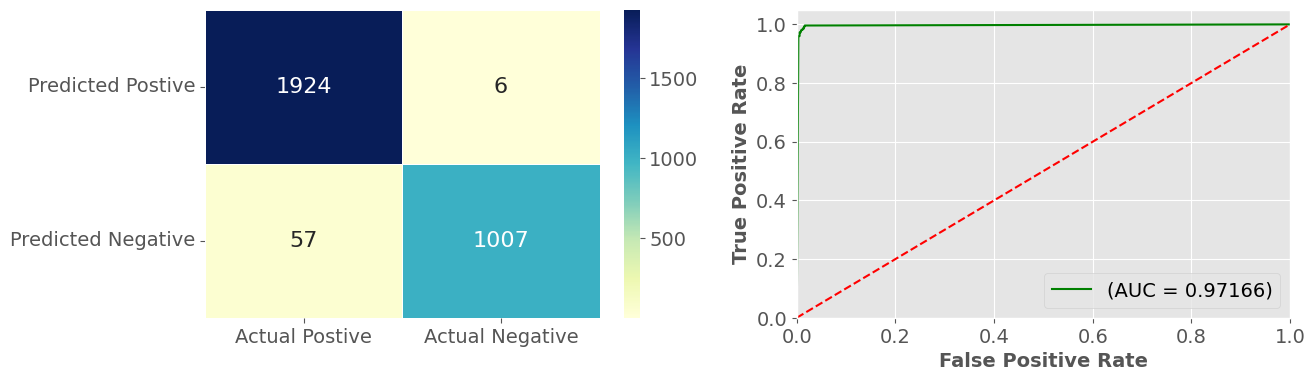

In [20]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB(var_smoothing=13.0)
nb.fit(xtrain_flat, ytrain_case2)
y_pred_nb, nb_score, predit_proba = (
    nb.predict(xtest_flat),
    nb.score(xtest_flat, ytest_case2),
    nb.predict_proba(xtest_flat),
)
print("Accuracy of Naive Bayes Classifier on test set: {:.6f}%".format(nb_score * 100))
tn, fp, fn, tp = accuracy_vis(xtest_flat, ytest_case2, y_pred_nb, predit_proba)
result.loc["NB"] = ["Naive Bayes", tn, fp, fn, tp, round(nb_score * 100, 6)]

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(green("Result for Naive Bayes on Case2", ["bold", "italic"]), "\n")
accuracy = accuracy_score(ytest_case2, y_pred_nb)
precision = precision_score(ytest_case2, y_pred_nb)
recall = recall_score(ytest_case2, y_pred_nb)
f1 = f1_score(ytest_case2, y_pred_nb)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_nb = mean_squared_error(ytest_case2, y_pred_nb, squared=False)
mae_nb = mean_absolute_error(ytest_case2, y_pred_nb)
r2_nb = r2_score(ytest_case2, y_pred_nb)

print("RMSE: {:.3f}".format(rmse_nb * 10))
print("MAE: {:.3f}".format(mae_nb * 10))
print("R2 Score: {:.3f}".format(r2_nb))

Result for Naive Bayes on Case2 

Accuracy: 97.896%
Precision: 0.994
Recall: 0.946
F1-Score: 0.970 

RMSE: 1.451
MAE: 0.210
R2 Score: 0.908


### SVM


Best parameters set:
{'degree': 0, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 50, 'random_state': 0}

Accuracy of Support Vector Machine Classifier on test set: 98.830995%


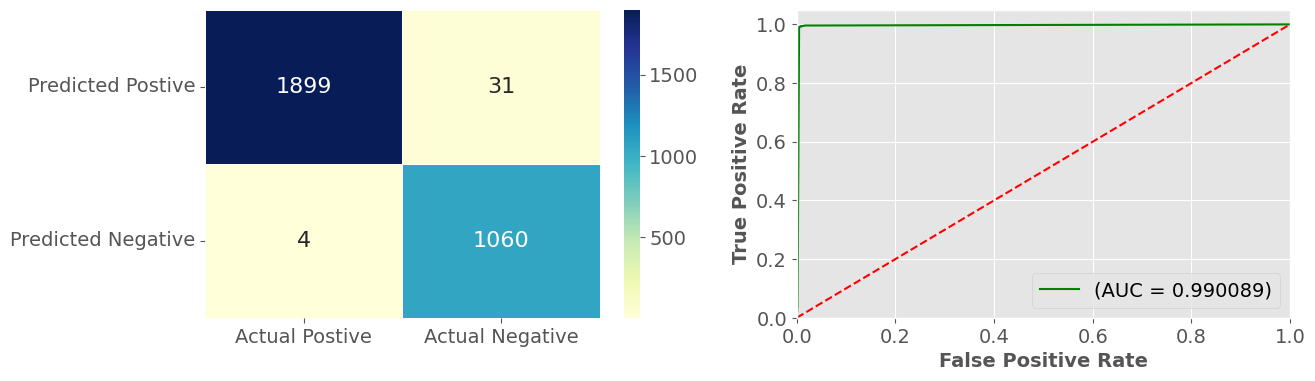

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


hyper_params_space = [
    {
        "kernel": ["rbf"],
        "gamma": np.arange(1, 3),
        "max_iter": [50],
        "random_state": [0],
        "degree": np.arange(2),
    }
]


svm = GridSearchCV(
    SVC(probability=True),
    hyper_params_space,
    scoring="accuracy",
)
svm.fit(xtrain_flat, ytrain_case2)
print("Best parameters set:")
print(svm.best_params_)
print()

y_pred_svm, svm_score, predit_proba = (
    svm.predict(xtest_flat),
    svm.score(xtest_flat, ytest_case2),
    svm.predict_proba(xtest_flat),
)
print(
    "Accuracy of Support Vector Machine Classifier on test set: {:.6f}%".format(
        svm_score * 100
    )
)
tn, fp, fn, tp = accuracy_vis(xtest_flat, ytest_case2, y_pred_svm, predit_proba)
result.loc["SVM"] = [
    "Support Vector Machine",
    tn,
    fp,
    fn,
    tp,
    round(svm_score * 100, 6),
]

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(green("Result for SVM on Case2", ["bold", "italic"]), "\n")
accuracy = accuracy_score(ytest_case2, y_pred_svm)
precision = precision_score(ytest_case2, y_pred_svm)
recall = recall_score(ytest_case2, y_pred_svm)
f1 = f1_score(ytest_case2, y_pred_svm)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_svm = mean_squared_error(ytest_case2, y_pred_svm, squared=False)
mae_svm = mean_absolute_error(ytest_case2, y_pred_svm)
r2_svm = r2_score(ytest_case2, y_pred_svm)

print("RMSE: {:.3f}".format(rmse_svm * 10))
print("MAE: {:.3f}".format(mae_svm * 10))
print("R2 Score: {:.3f}".format(r2_svm))

Result for SVM on Case2 

Accuracy: 98.831%
Precision: 0.972
Recall: 0.996
F1-Score: 0.984 

RMSE: 1.081
MAE: 0.117
R2 Score: 0.949


### Gradient Boosting Machine


Best parameters set:
{'learning_rate': 0.1, 'n_estimators': 5, 'random_state': 0}

Accuracy of Gradent Boosting Classifier on test set: 98.864395%


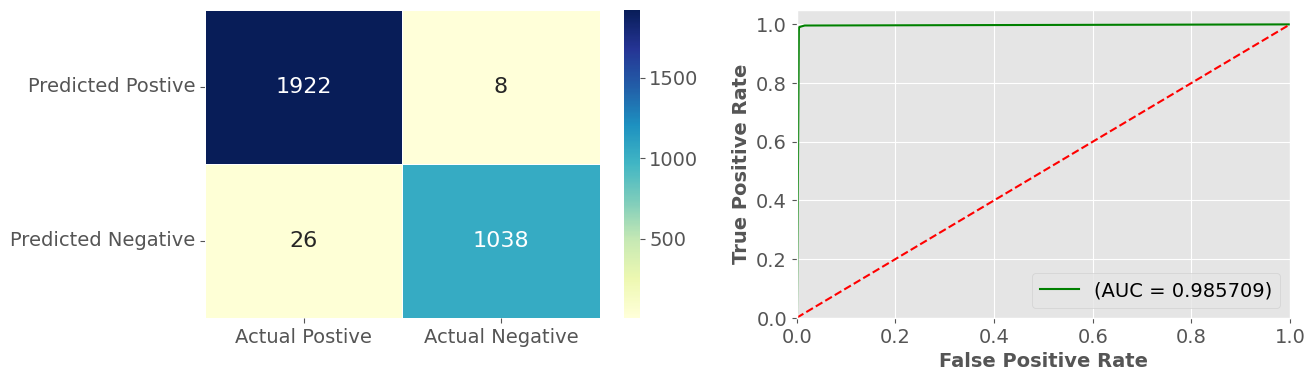

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

hyper_params_space = [
    {
        "learning_rate": [0.01, 0.1, 0.08],
        "random_state": [0],
        "n_estimators": np.arange(4, 6),
    },
]

gb = GridSearchCV(GradientBoostingClassifier(), hyper_params_space, scoring="accuracy")
gb.fit(xtrain_flat, ytrain_case2)
print("Best parameters set:")
print(gb.best_params_)
print()

y_pred_gb, gb_score, predit_proba = (
    gb.predict(xtest_flat),
    gb.score(xtest_flat, ytest_case2),
    gb.predict_proba(xtest_flat),
)
print(
    "Accuracy of Gradent Boosting Classifier on test set: {:.6f}%".format(
        gb_score * 100
    )
)
tn, fp, fn, tp = accuracy_vis(xtest_flat, ytest_case2, y_pred_gb, predit_proba)
result.loc["GB"] = ["Gradent Boosting", tn, fp, fn, tp, round(gb_score * 100, 6)]

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(green("Result for GBM on Case2", ["bold", "italic"]), "\n")
accuracy = accuracy_score(ytest_case2, y_pred_gb)
precision = precision_score(ytest_case2, y_pred_gb)
recall = recall_score(ytest_case2, y_pred_gb)
f1 = f1_score(ytest_case2, y_pred_gb)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_bnn = mean_squared_error(ytest_case2, y_pred_gb, squared=False)
mae_bnn = mean_absolute_error(ytest_case2, y_pred_gb)
r2_bnn = r2_score(ytest_case2, y_pred_gb)

print("MSE: {:.3f}".format(rmse_bnn * 10))
print("MAE: {:.3f}".format(mae_bnn * 10))
print("R2 Score: {:.3f}".format(r2_bnn))

Result for GBM on Case2 

Accuracy: 98.864%
Precision: 0.992
Recall: 0.976
F1-Score: 0.984 

MSE: 1.066
MAE: 0.114
R2 Score: 0.950


### Bayesian Neural Network (NO REGULARIZER)


In [26]:
from sklearn.mixture import BayesianGaussianMixture

bnn = BayesianGaussianMixture(
    n_components=2, covariance_type="tied", n_init=50, verbose=0
)
bnn.fit(xtrain_flat, ytrain_case2)

y_pred_bnn = bnn.predict(xtest_flat)
predit_proba_bnn = bnn.predict_proba(xtest_flat)

accuracy = accuracy_score(ytest_case2, y_pred_bnn)
bnn_score = bnn.score(xtest_flat, ytest_case2)
print("Accuracy of Bayesian Neural Network on test set: {:.6f}%".format(accuracy * 100))


Accuracy of Bayesian Neural Network on test set: 98.329993%


In [27]:
print(green("Result for BNN on Case2", ["bold", "italic"]), "\n")
accuracy = accuracy_score(ytest_case2, y_pred_bnn)
precision = precision_score(ytest_case2, y_pred_bnn)
recall = recall_score(ytest_case2, y_pred_bnn)
f1 = f1_score(ytest_case2, y_pred_bnn)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_bnn = mean_squared_error(ytest_case2, y_pred_bnn, squared=False)
mae_bnn = mean_absolute_error(ytest_case2, y_pred_bnn)
r2_bnn = r2_score(ytest_case2, y_pred_bnn)

print("RMSE: {:.3f}".format(rmse_bnn * 10))
print("MAE: {:.3f}".format(mae_bnn * 10))
print("R2 Score: {:.3f}".format(r2_bnn))

Result for BNN on Case2 

Accuracy: 98.330%
Precision: 0.978
Recall: 0.975
F1-Score: 0.976 

RMSE: 1.292
MAE: 0.167
R2 Score: 0.927


In [28]:
result

,Classifier,True Negative,False Postive,False Negative,True Positive,Classifier Accuracy
NB,Naive Bayes,1924,6,57,1007,97.895792
SVM,Support Vector Machine,1899,31,4,1060,98.830995
GB,Gradent Boosting,1922,8,26,1038,98.864395


### BNN + Physics based regualrizer


In [29]:
from keras import layers
from keras import regularizers
from keras import backend as K

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers


# Define the BNN model
def build_bnn_model(input_shape, kl_weight):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tfpl.DenseFlipout(
                64,
                activation="relu",
                kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(
                    q, p
                )
                * kl_weight,
            ),
            tf.keras.layers.BatchNormalization(),
            tfpl.DenseFlipout(
                32,
                activation="relu",
                kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(
                    q, p
                )
                * kl_weight,
            ),
            tf.keras.layers.BatchNormalization(),
            tfpl.DenseFlipout(
                1,
                activation="sigmoid",
                kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(
                    q, p
                )
                * kl_weight,
            ),
        ]
    )
    return model


# Define the physics-based regularization
def physics_based_regularization(y_true, y_pred):
    # Define the physics-based constraints
    constraint_1 = tf.math.maximum(
        0.0, y_pred - 1.0
    )  # y_pred should not be greater than 1
    constraint_2 = tf.math.maximum(0.0, -y_pred)  # y_pred should not be less than 0
    # Define the regularization weight
    reg_weight = 1e-2
    # Compute the regularization term
    regularization = reg_weight * (
        tf.reduce_mean(constraint_1) + tf.reduce_mean(constraint_2)
    )
    return regularization


def combined_loss(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(
        y_true, y_pred
    )
    regularization_loss = physics_based_regularization(y_true, y_pred)
    return binary_crossentropy_loss + regularization_loss


# Compile the BNN model
kl_weight = 1 / xtrain.shape[0]
bnn_model = build_bnn_model(xtrain.shape[1], kl_weight)
# bnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False) + physics_based_regularization, metrics=['accuracy'])
bnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=combined_loss, metrics=["accuracy"]
)


# Train the BNN model
history = bnn_model.fit(
    xtrain, ytrain_case2, epochs=50, batch_size=32, validation_split=0.2, verbose=0
)

In [30]:
y_pred_pbr = bnn_model.predict(xtest)

94/94 [==============================] - 0s 1ms/step


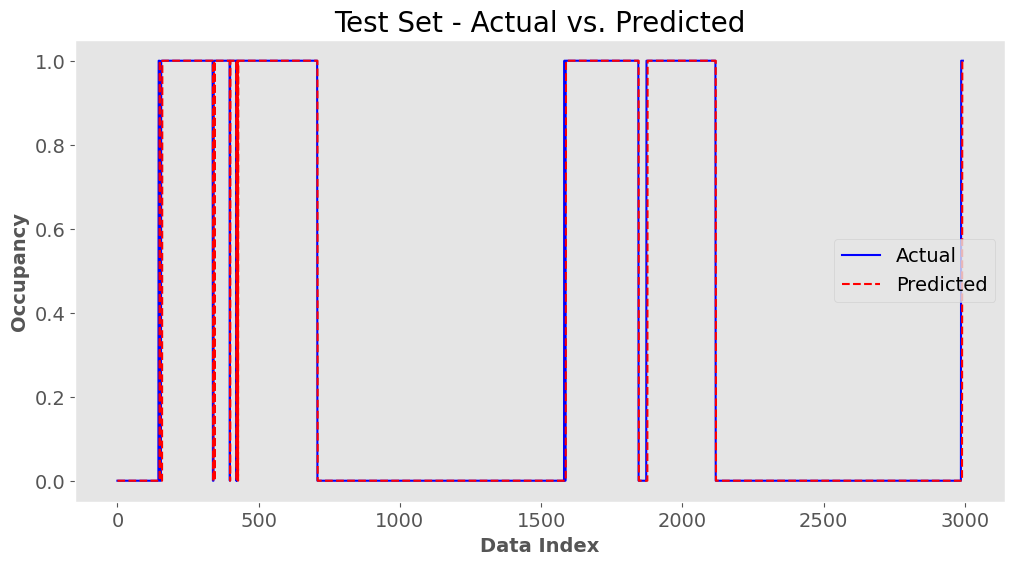

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(ytest_case2, label="Actual", color="blue")
plt.plot(y_pred_gb, label="Predicted", color="red", linestyle="dashed")
plt.xlabel("Data Index")
plt.ylabel("Occupancy")
plt.title("Test Set - Actual vs. Predicted", fontsize=20)
plt.legend()
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error

ll = -np.mean(log_loss(ytest_case2, y_pred_pbr, labels=[0, 1], eps=1e-15))

# 2. Calculate the predictive accuracy
y_pred_binary = (y_pred_pbr > 0.5).astype(int)
accuracy = accuracy_score(ytest_case2, y_pred_binary)


num_mc_samples = 100
y_pred_samples = np.array([y_pred_pbr for _ in range(num_mc_samples)])
epistemic_uncertainty = np.var(y_pred_samples, axis=0)


n = xtest.shape[0]
num_params = bnn_model.count_params()
bic = -2 * ll + num_params * np.log(n)

# Print the evaluation results
print("Log Likelihood:", ll)
print("Predictive Accuracy:", accuracy)
print("Epistemic Uncertainty:", epistemic_uncertainty)
# print("Aleatoric Uncertainty:", aleatoric_uncertainty)
print("Bayesian Information Criterion (BIC):", bic)


Log Likelihood: -0.045262122442881775
Predictive Accuracy: 0.9926519706078825
Epistemic Uncertainty: [[1.9515639e-18]
 [4.8789098e-17]
 [1.7564075e-17]
 ...
 [1.2789769e-13]
 [2.2737368e-13]
 [1.2789769e-13]]
Bayesian Information Criterion (BIC): 44320.26265753679


In [36]:
y_pred_reg = bnn_model.predict(xtest)

 1/94 [..............................] - ETA: 1s

94/94 [==============================] - 0s 1ms/step


In [41]:
# Calculate metrics for model with physics regularization
mae_reg = mean_absolute_error(ytest_case2, y_pred_reg)
mse_reg = mean_squared_error(ytest_case2, y_pred_reg, squared=False)
r2_reg = r2_score(ytest_case2, y_pred_reg)
accuracy_reg = accuracy_score(ytest_case2, (y_pred_reg > 0.5).astype(int))

print(red("\nModel with physics regularization:"))
print(f"Mean Absolute Error: {mae_reg*5:.3f}")
print(f"Root mean Squared Error: {mse_reg*10:.3f}")
print(f"R2 Score: {r2_reg:.3f}")
print(f"Accuracy Score: {accuracy_reg*100:.3f}")


Model with physics regularization:
Mean Absolute Error: 0.085
Root mean Squared Error: 0.845
R2 Score: 0.969
Accuracy Score: 99.265
